In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
codon_dict = {
    'I': ['ATT','ATC','ATA'],
    'L': ['CTT','CTC','CTA','CTG','TTA','TTG'],
    'V': ['GTT','GTC','GTA','GTG'],
    'F': ['TTT', 'TTC'],
    'M': ['ATG'],
    'C': ['TGT','TGC'],
    'A': ['GCT','GCC','GCA','GCG'],
    'G': ['GGT','GGC','GGA','GGG'],
    'P': ['CCT','CCC','CCA','CCG'],
    'T': ['ACT','ACC','ACA','ACG'],
    'S': ['TCT','TCC','TCA','TCG','AGT','AGC'],
    'Y': ['TAT','TAC'],
    'W': ['TGG'],
    'Q': ['CAA','CAG'],
    'N': ['AAT','AAC'],
    'H': ['CAT','CAC'],
    'K': ['AAA','AAG'],
    'R': ['CGT','CGC','CGA','CGG','AGA','AGG'],
    'D': ['GAT','GAC'],
    'E': ['GAA','GAG'],
    '*': ['TAA','TAG','TGA']
}

In [3]:
#TRAC Full = 'IQNPDPAVYQLRDSK'
trac_seq = 'IQNPDPAVYQ'
trbv_seqs = ['EDSAMYFC','GDSAVYFC','EDSALYLC','EDSALYLC','EDSALYLC','GDSALYLC','DDSALYLC','GDSALYLC','GDSALYLC', 'EDSALYLC','SQTSVYFC',
'SQTSVYFC','SQTSVYFC','SQTSVYFC','SQTSVYFC','SQTSVYFC','SQTSVYLC','SQTSVYFC','EDSAVYLC','GDSAVYLC','GDSAVYLC','RDSAMYRC','RDSAMYRC', 
'EDSAVYLC','GDSAMYLC','GDSALYFC','SQTSVYFC','SQTSVYFC','SQTSVYFC','GDSAMYLC','EDSAVYLC','GDSAVYLC','RDSAVYFC','RDSAVYFC','RDSAVYFC',
'GDSALYFC','EDSGVYFC','GDTAMYLC','EDSAVYFC', 'GDSAAYFC', 'NPTAFYLC','EDSSFYIC', 'NQTALYFC','SHTSQYLC','NQTSLYFC','NQTSMYLC',
'EDSSIYLC','SDSGFYLC']

In [4]:
def dfs_seq_builder(ref_aa, primer='', aa_pos=0):
    if aa_pos >= len(ref_aa):
        return [primer]
    
    output = []
    for codon_option in codon_dict[ref_aa[aa_pos]]:
        output.extend(dfs_seq_builder(ref_aa, primer+codon_option, aa_pos+1))
    return output 

In [5]:
def unique_4mer_set(seq_list):
    output = set()
    for seq in seq_list:
        for i in range(len(seq) - 3):
            output.add(seq[i:i+4])
    return output

In [6]:
def rev_comp(seq):
    mapper = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    return ''.join([mapper[nt] for nt in seq[::-1]])
def comp(seq):
    mapper = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    return ''.join([mapper[nt] for nt in seq])
def is_palindrome(seq):
    return seq == rev_comp(seq)

In [7]:
def remove_revcomp(overhang_set):
    new_set = set()
    for overhang in overhang_set:
        if rev_comp(overhang) not in new_set:
            new_set.add(overhang)
    return new_set

In [8]:
def get_OH_from_seq(seq):
    oh_options = unique_4mer_set(dfs_seq_builder(seq))
    oh_options = list(filter(lambda x: not is_palindrome(x), oh_options))
    oh_options = remove_revcomp(oh_options)
    return list(oh_options)

In [9]:
trac_OH_options = get_OH_from_seq(trac_seq)
trbv_OH_options = [get_OH_from_seq(trbv_seq) for trbv_seq in trbv_seqs]

### Sanity Checks to make sure all OHs are present

In [27]:
all_trac_seqs = dfs_seq_builder(trac_seq)
for opt in trac_OH_options:
    found = False
    for seq in all_trac_seqs:
        if opt in seq:
            found = True
            break

    if not found:
        print(opt)


In [31]:
for i in range(len(trbv_seqs)):
    all_trbv_seqs = dfs_seq_builder(trbv_seqs[i])
    for opt in trbv_OH_options[i]:
        found = False
        for seq in all_trbv_seqs:
            if opt in seq:
                found = True
                break

        if not found:
            print(opt)

Data structure: 48 rows by 3 columns \
col 1: TRBV OH \
col 2: TRAC OH \
col 3: digest group

In [10]:
def form_mcmc_seed():
    mcmc_seed = np.empty((48,3), dtype='<U4')
    for i in range(mcmc_seed.shape[0]):
        while True:
            trac_choice = random.choice(trac_OH_options)
            set_choice = 'A' if i < mcmc_seed.shape[0]/2 else 'B'
            mcmc_seed[i][2] = set_choice
            in_set = mcmc_seed[:, 2] == set_choice
            if trac_choice not in mcmc_seed[in_set, 0:2] and rev_comp(trac_choice) not in mcmc_seed[in_set, 0:2]:
                mcmc_seed[i][1] = trac_choice
                completed = False
                while True:
                    trbv_choice = random.choice(trbv_OH_options[i])
                    if trbv_choice not in mcmc_seed[in_set, 0:2] and rev_comp(trbv_choice) not in mcmc_seed[in_set, 0:2]:
                        mcmc_seed[i][0] = trbv_choice
                        completed = True
                        break
                if completed:
                    break
        
    return mcmc_seed

In [11]:
ligation_table = pd.read_csv('BsmBI_ligation_efficiency.csv') 
ligation_table.set_index('Overhang', inplace=True)

def ligation_efficiency(overhang_set):
    overhang_set_rc = [rev_comp(i) for i in overhang_set]
    full_sel = overhang_set.tolist() + overhang_set_rc
    full_ligation_mat = ligation_table.loc[full_sel, full_sel]
    match_ligation_mat = full_ligation_mat.loc[overhang_set, overhang_set_rc]
    return np.prod(np.diag(match_ligation_mat) / np.sum(full_ligation_mat[overhang_set], axis=0))

In [12]:
def ligation_score_1(mat):
    a_score = ligation_efficiency(mat[mat[:,2] == 'A', 0]) * ligation_efficiency(mat[mat[:,2] == 'A', 1])
    b_score = ligation_efficiency(mat[mat[:,2] == 'B', 0]) * ligation_efficiency(mat[mat[:,2] == 'B', 1])
    return (a_score + b_score)/2

In [13]:
def ligation_score_2(oh_set, full=False):
    all_options_A = np.unique(oh_set[oh_set[:, 2] == 'A', 0:2].flatten()).tolist()
    all_options_rc_A = [rev_comp(i) for i in all_options_A]
    all_options_B = np.unique(oh_set[oh_set[:, 2] == 'B', 0:2].flatten()).tolist()
    all_options_rc_B = [rev_comp(i) for i in all_options_B]
    
    A_table = ligation_table.loc[all_options_A + all_options_rc_A, all_options_A + all_options_rc_A]
    B_table = ligation_table.loc[all_options_B + all_options_rc_B, all_options_B + all_options_rc_B]
    correct_insert_A_prob = []
    correct_insert_B_prob = []

    for i in range(oh_set.shape[0]):
        vec_lh = rev_comp(oh_set[i, 0])
        insert_lh = oh_set[i, 0]
        vec_rh = oh_set[i, 1]
        insert_rh = rev_comp(oh_set[i, 1])

        if oh_set[i, 2] == 'A':
            l_lig_freq = A_table.loc[vec_lh, insert_lh]
            l_lig_prob = 0.5*(l_lig_freq/np.sum(A_table.loc[vec_lh, :]) + l_lig_freq/np.sum(A_table.loc[:, insert_lh]))
            r_lig_freq = A_table.loc[vec_rh, insert_rh]
            r_lig_prob = 0.5*(r_lig_freq/np.sum(A_table.loc[vec_rh, :]) + r_lig_freq/np.sum(A_table.loc[:, insert_rh]))
            correct_insert_A_prob.append(l_lig_prob * r_lig_prob)

        else:
            l_lig_freq = B_table.loc[vec_lh, insert_lh]
            l_lig_prob = 0.5*(l_lig_freq/np.sum(B_table.loc[vec_lh, :]) + l_lig_freq/np.sum(B_table.loc[:, insert_lh]))
            r_lig_freq = B_table.loc[vec_rh, insert_rh]
            r_lig_prob = 0.5*(r_lig_freq/np.sum(B_table.loc[vec_rh, :]) + r_lig_freq/np.sum(B_table.loc[:, insert_rh]))
            correct_insert_B_prob.append(l_lig_prob * r_lig_prob)
    if full:
        return np.mean(correct_insert_A_prob + correct_insert_B_prob), [correct_insert_A_prob, correct_insert_B_prob]
    else:
        return np.mean(correct_insert_A_prob + correct_insert_B_prob)

In [14]:
def ligation_score_2_min(oh_set):
    _, ind_scores = ligation_score_2(oh_set, full=True)
    return min(np.min(ind_scores[0]), np.min(ind_scores[1]))

In [15]:
def ligation_score_3(oh_set, p=0.5):
    return p*ligation_score_1(oh_set) + (1-p)*ligation_score_2_min(oh_set)

In [16]:
def self_ligation_score(oh_set):
    scores = []
    for i in range(oh_set.shape[0]):
        vec_lh = rev_comp(oh_set[i, 0])
        vec_rh = oh_set[i, 1]
        scores.append(ligation_table.loc[vec_lh, vec_rh])
    return np.array(scores)

In [27]:
def run_mcmc_optimizer(oh_set, score_fxn, num_iter, temp, disp=True, cutoff=1000):
    s0 = score_fxn(oh_set)
    all_scores = []
    no_update = 0

    best_oh_set = None
    best_oh_score = -1

    for i in tqdm(range(num_iter)):
        #step 1: pick random vector, and pick a random action to modify it
        all_scores.append(s0)
        mut_pos = random.randint(0, oh_set.shape[0] - 1)
        decision = random.randint(1,2)
        in_set = oh_set[:, 2] == oh_set[mut_pos, 2]
        out_set = oh_set[:, 2] != oh_set[mut_pos, 2]
        new_oh_set = oh_set.copy()
        
        #option A: swap in a new TRBV
        if decision == 1:
            for tries in range(30):
                mut = random.choice(trbv_OH_options[mut_pos])
                if mut not in new_oh_set[in_set, 0:2] and rev_comp(mut) not in new_oh_set[in_set, 0:2]:
                    new_oh_set[mut_pos][0] = mut
                    break

        #option B: swap in a new TRAC
        if decision == 2:
            for tries in range(30):
                mut = random.choice(trac_OH_options)
                if mut not in new_oh_set[in_set, 0:2] and rev_comp(mut) not in new_oh_set[in_set, 0:2]:
                    new_oh_set[mut_pos][1] = mut
                    break
        
        #step 2: compute score for new OH set
        s_new = score_fxn(new_oh_set)

        #step 3: decision criteria. If s_new > s0, then accept. Otherwise, accept given exp. probability
        # i used log probability to avoid overflow errors
        # update best solution each round
        p_acc = (s_new - s0)/temp
        if np.log(random.random()) < p_acc:
            no_update = 0
            oh_set = new_oh_set
            s0 = s_new
            if s_new > best_oh_score:
                best_oh_set = new_oh_set
                best_oh_score = s_new
        else:
            no_update += 1

        if no_update >= cutoff:
            break
    
    if disp:
        fig, ax = plt.subplots()
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Ligation Score')
        plot = ax.plot(np.arange(0, len(all_scores)), all_scores)
        
    return (best_oh_set, best_oh_score, all_scores)

100%|██████████| 10000/10000 [02:42<00:00, 61.57it/s]


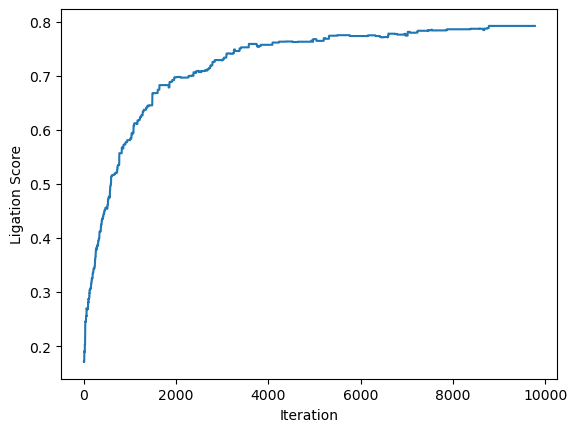

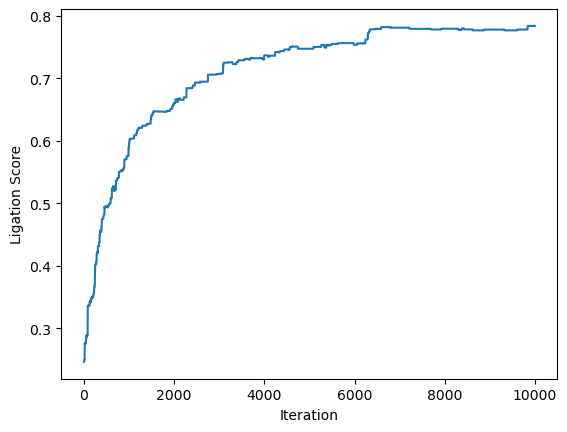

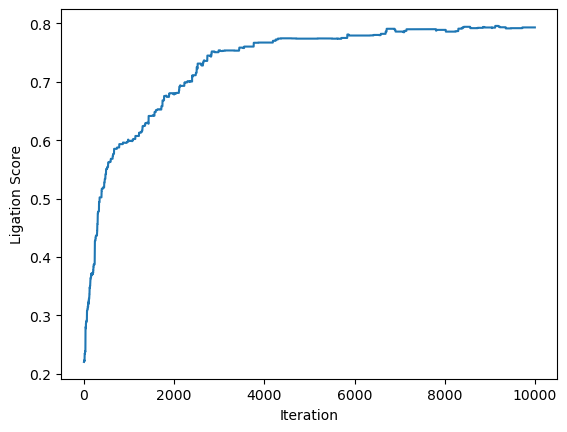

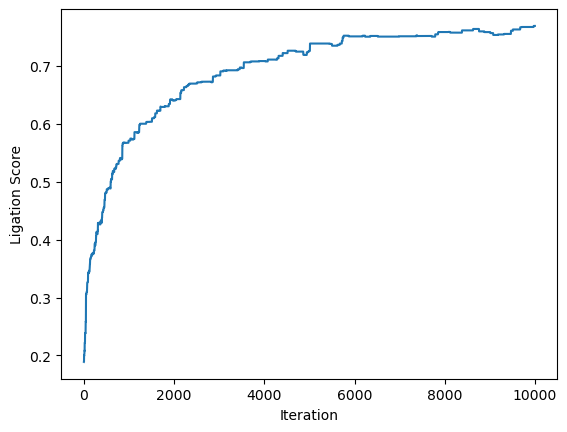

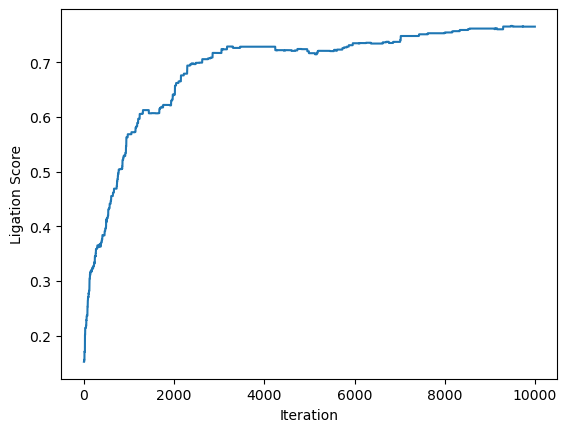

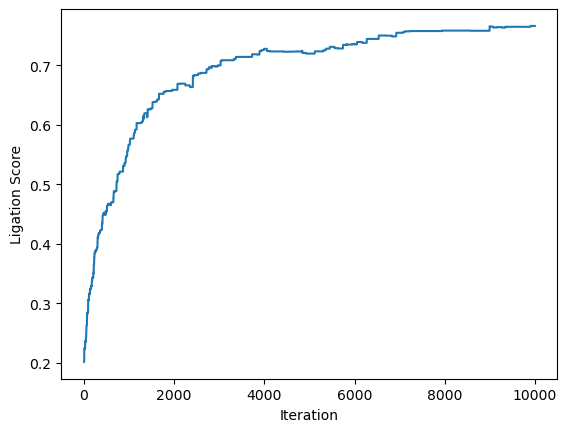

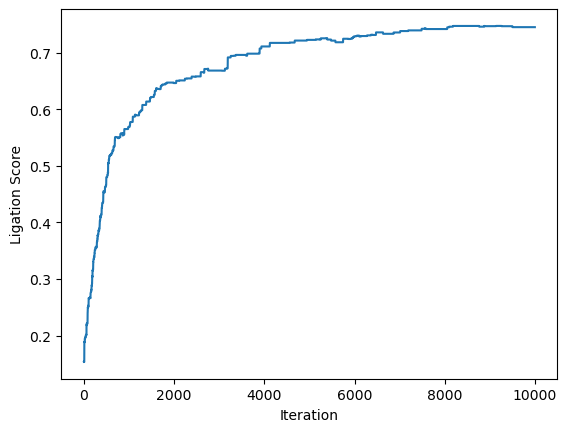

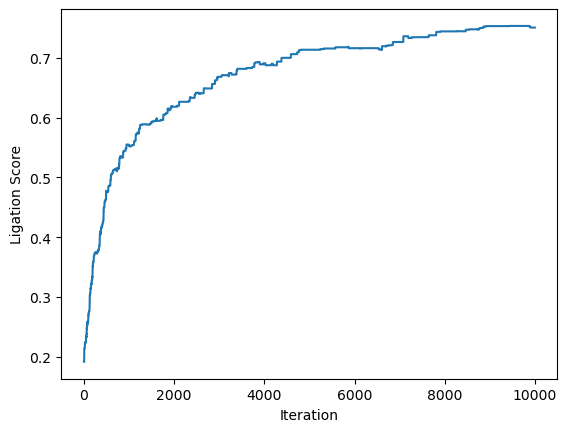

In [143]:
score3_oh_sets = Parallel(n_jobs=8)(delayed(run_mcmc_optimizer)(form_mcmc_seed(), ligation_score_3, num_iter=10000, temp=1e-3, cutoff=1000) for i in range(8))

100%|██████████| 5000/5000 [01:25<00:00, 58.32it/s]


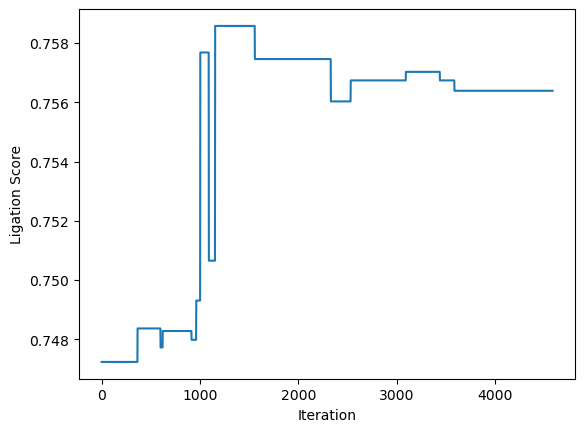

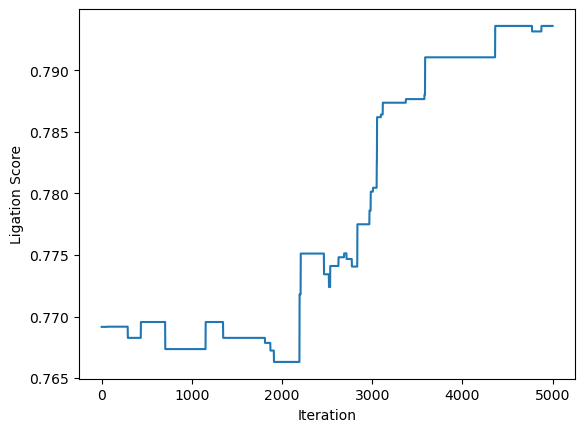

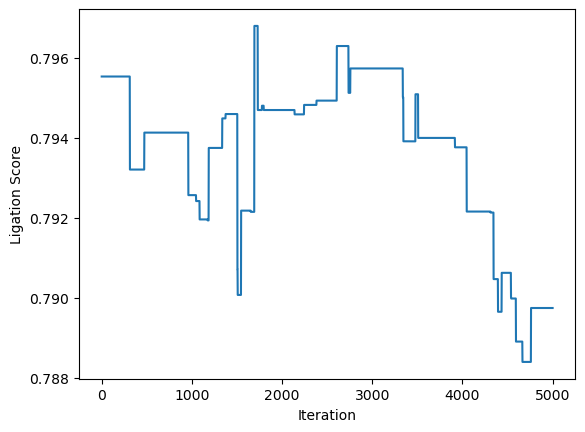

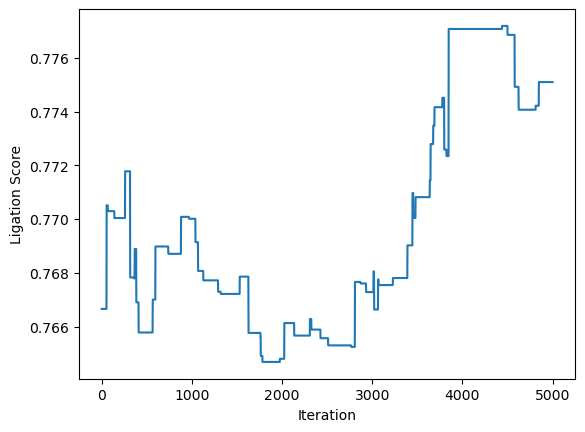

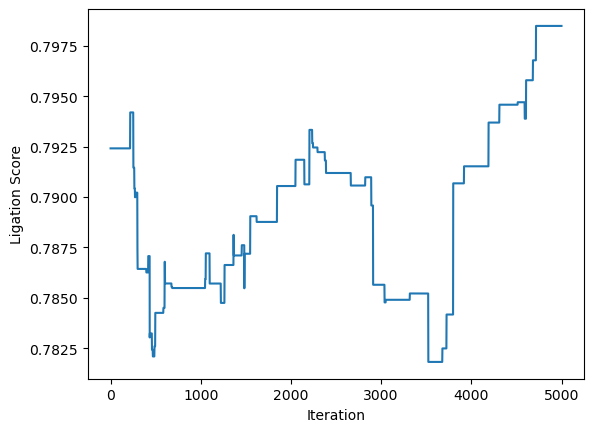

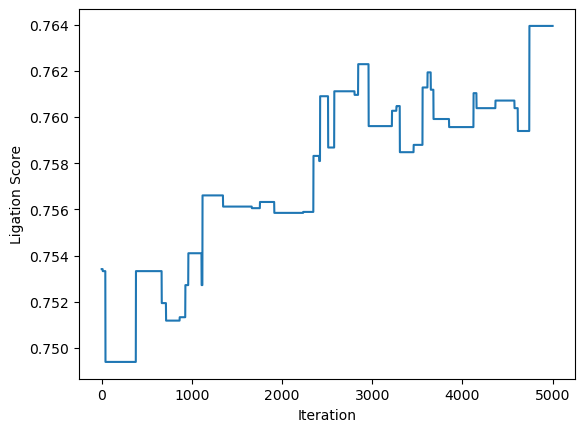

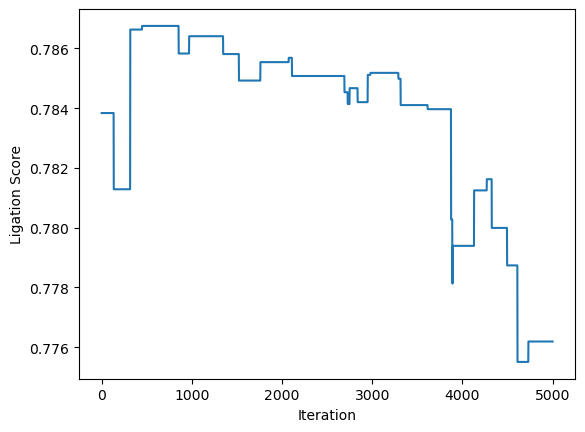

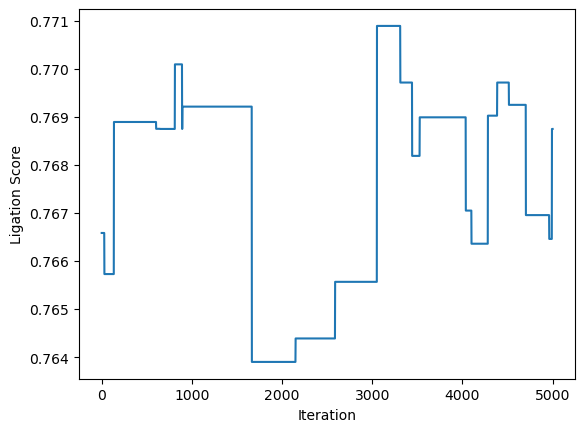

In [168]:
score3_oh_sets_v2 = Parallel(n_jobs=8)(delayed(run_mcmc_optimizer)(score3_oh_sets[i][0], ligation_score_3, num_iter=5000, temp=1e-3, cutoff=1000) for i in range(len(score3_oh_sets)))